<a href="https://colab.research.google.com/github/GamingBoyOfficial/MarketSignalBacktesting/blob/main/MarketSignalAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install backtesting yfinance Ta-Lib --quiet

import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yk
import pandas as pd
import numpy as np
import talib

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 55.6 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [2]:
class SMAStrategy(Strategy):

  def init(self):
    price = self.data.Close
    self.m10 = self.I(SMA, price, 10)
    self.m20 = self.I(SMA, price, 20)

  def next(self):
    if crossover(self.m10,self.m20) : self.buy()
    elif crossover(self.m20,self.m10) : self.sell()


In [3]:
class MACDStrategy(Strategy):

  def init(self):
    price = self.data.Close
    self.macd = self.I(lambda x: talib.MACD(x)[0], price)
    self.macd_signal = self.I(lambda x: talib.MACD(x)[1], price)

  def next(self):
    if crossover(self.macd,self.macd_signal) : self.buy()
    elif crossover(self.macd_signal,self.macd) : self.sell()

In [4]:
stock = "NVDA"
begin = dt.datetime(2020,1,1)
finish = dt.datetime(2025,1,1)
data = yk.download(stock, start = begin, end = finish)
data.columns = data.columns.get_level_values(0)

data.head()

/tmp/ipython-input-4289031199.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yk.download(stock, start = begin, end = finish)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,5.971078,5.971078,5.891683,5.942207,237536000
2020-01-03,5.875504,5.919308,5.826473,5.851362,205384000
2020-01-06,5.900145,5.905372,5.756039,5.782172,262636000
2020-01-07,5.971576,6.017372,5.883470,5.928518,314856000
2020-01-08,5.982777,6.024092,5.927275,5.967345,277108000


In [5]:
sma_bt = Backtest(data, SMAStrategy, commission=0.002, exclusive_orders=True)
macd_bt = Backtest(data, MACDStrategy, commission=0.002, exclusive_orders=True)

sma_stats = sma_bt.run()
macd_stats = macd_bt.run()

print("SMA Strategy Results")
print(sma_stats)

print("\nMACD Strategy Results")
print(macd_stats)

Backtest.run:   0%|          | 0/1238 [00:00<?, ?bar/s]

/tmp/ipython-input-3260403857.py:4: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  sma_stats = sma_bt.run()


Backtest.run:   0%|          | 0/1224 [00:00<?, ?bar/s]

/tmp/ipython-input-3260403857.py:5: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  macd_stats = macd_bt.run()


SMA Strategy Results
Start                     2020-01-02 00:00:00
End                       2024-12-31 00:00:00
Duration                   1825 days 00:00:00
Exposure Time [%]                    96.50238
Equity Final [$]                   20391.4543
Equity Peak [$]                   30297.01054
Commissions [$]                     4085.6338
Return [%]                          103.91454
Buy & Hold Return [%]              2094.42639
Return (Ann.) [%]                    15.34215
Volatility (Ann.) [%]                63.09339
CAGR [%]                             10.33906
Sharpe Ratio                          0.24317
Sortino Ratio                         0.46388
Calmar Ratio                           0.2393
Alpha [%]                          -264.00087
Beta                                  0.17566
Max. Drawdown [%]                   -64.11238
Avg. Drawdown [%]                   -10.73338
Max. Drawdown Duration      919 days 00:00:00
Avg. Drawdown Duration       70 days 00:00:00
# Trades     

In [6]:
sma_bt.plot()
macd_bt.plot()

GridPlot(id='p1800', ...)

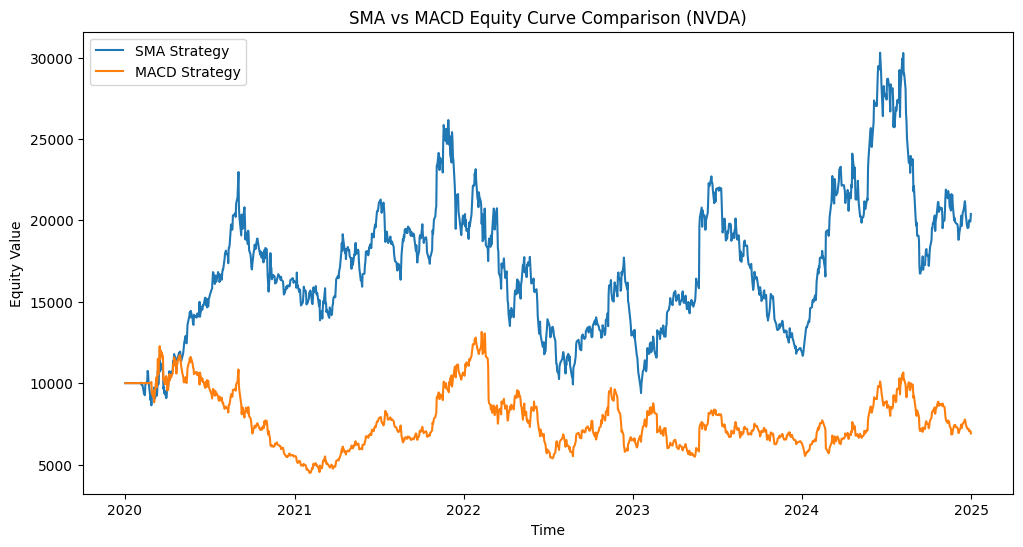

In [7]:
sma_curve = sma_stats._equity_curve['Equity']
macd_curve = macd_stats._equity_curve['Equity']

plt.figure(figsize=(12,6))
plt.plot(sma_curve, label="SMA Strategy")
plt.plot(macd_curve, label="MACD Strategy")
plt.legend()
plt.title("SMA vs MACD Equity Curve Comparison (NVDA)")
plt.xlabel("Time")
plt.ylabel("Equity Value")
plt.show()

In [8]:
def sharpe_ratio(equity_curve):
  returns = equity_curve.pct_change().dropna()
  sharpe = (returns.mean() / returns.std()) * np.sqrt(252)
  return round(sharpe, 2)

print("SMA Sharpe Ratio:", sharpe_ratio(sma_curve))
print("MACD Sharpe Ratio:", sharpe_ratio(macd_curve))

SMA Sharpe Ratio: 0.53
MACD Sharpe Ratio: 0.11
